### Import Libararies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
import nltk
from nltk.corpus import stopwords
import cv2

### Getting the Training Data

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir /.kaggle

! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-11-10 18:11:20          15762  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           9534  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4307  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3494  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
!kaggle datasets download -d jainamshah17/flicker8k-image-captioning

100% 1.16G/1.16G [00:12<00:00, 82.9MB/s]
100% 1.16G/1.16G [00:12<00:00, 101MB/s] 


In [ ]:
!unzip /content/flicker8k-image-captioning.zip

**Reading Text Captions**

In [ ]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [ ]:
captions = readTextFile("/content/Flickr8k_text/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]

In [ ]:
captions

In [ ]:
first,second  = captions[10].split('\t')
print(first)
print(second)

1002674143_1b742ab4b8.jpg#0
A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .


**Dictionary to Map each image with the list of captions it has**

In [ ]:
descriptions = {}
for x in captions:
    first,second = x.split('\t')
    image_name = first.split(".")[0]
    # if the image id is already present or not
    if descriptions.get(image_name) is None:
        descriptions[image_name] = []
    descriptions[image_name].append(second)

In [ ]:
descriptions["1002674143_1b742ab4b8"]

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
 'A little girl is sitting in front of a large painted rainbow .',
 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
 'There is a girl with pigtails sitting in front of a rainbow painting .',
 'Young girl with pigtails painting outside in the grass .']

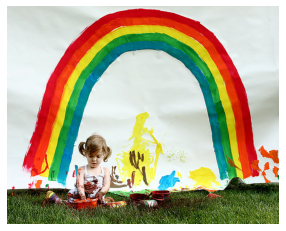

In [ ]:
img_path = "/content/Flickr8k_Dataset/Flicker8k_Dataset/"
img = cv2.imread(img_path + "1002674143_1b742ab4b8.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

**Data Cleaning**

In [ ]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]", " ", sentence)
    sentence = sentence.split()
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [ ]:
clean_text("A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it . #12")

'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it'

In [ ]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [ ]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

**Vocabulary**

In [ ]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


**Total No of words across all the sentences**

In [ ]:
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total Words" , len(total_words))

Total Words 373837


**Filter Words from the Vocab according to certain threshold frequncy**

In [ ]:

import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [ ]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]


print(len(total_words))

1845


**Prepare Train and Test Data**

In [ ]:
train_file_data = readTextFile("/content/Flickr8k_text/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("/content/Flickr8k_text/Flickr_8k.testImages.txt")

In [ ]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [ ]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
# Prepare Description for the Training Data
# Tweak - Add <s> and <e> token to our training data

train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [ ]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

**Transfer learning**

In [ ]:
from tensorflow.keras.applications.xception import Xception,preprocess_input,decode_predictions
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Input,Dense,Dropout,Embedding,LSTM
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow

In [ ]:
model = tensorflow.keras.applications.efficientnet.EfficientNetB7(weights='imagenet', input_shape=(600,600,3))
model.summary()

In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(600,600))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1))
    return feature_vector

In [ ]:
encode_img(img_path + "1000268201_693b08cb0e.jpg")

array([-0.02234085, -0.08723496, -0.15755104, ..., -0.16601002,
       -0.147264  , -0.10946663], dtype=float32)

In [ ]:
encoding_train = {}
for img_id in train:
    PATH = img_path + img_id + ".jpg"
    encoding_train[img_id] = encode_img(PATH)

In [ ]:
encoding_test = {}
for img_id in test:
    PATH = img_path + img_id + ".jpg"
    encoding_test[img_id] = encode_img(PATH)

In [ ]:
import pickle

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

**Data PreProcessing For Captions**

In [ ]:
# Vocab
len(total_words)

1845

In [ ]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [ ]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847
vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [ ]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))

print(max_len)

35


**Data Loader (Generator)**

In [ ]:
from tensorflow.keras.utils import to_categorical
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]

    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1

            photo = encoding_train[key]
            for desc in desc_list:

                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]

                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield ([np.array(X1),np.array(X2)],np.array(y))
                    X1,X2,y = [],[],[]
                    n = 0

In [ ]:
!kaggle datasets download -d watts2/glove6b50dtxt

 64% 43.0M/67.7M [00:00<00:00, 49.0MB/s]
100% 67.7M/67.7M [00:00<00:00, 115MB/s] 


In [ ]:
!unzip /content/glove6b50dtxt.zip

Archive:  /content/glove6b50dtxt.zip
  inflating: glove.6B.50d.txt        


**Word Embeddings**

In [ ]:
f = open("/content/glove.6B.50d.txt",encoding='utf8')

In [ ]:
embedding_index = {}
for line in f :
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype = 'float')
    embedding_index[word] = word_embedding

In [ ]:
embedding_index['machine']

array([-0.34165  , -0.81267  ,  1.4513   ,  0.05914  , -0.080801 ,
        0.39567  ,  0.10064  , -0.5468   , -0.18887  ,  0.11364  ,
       -0.040956 , -0.5637   , -0.32191  ,  0.15968  , -0.59756  ,
       -0.14571  , -0.77074  ,  1.2955   , -0.72002  , -0.90818  ,
        0.76644  ,  0.05346  , -0.0031632, -0.15341  ,  0.22065  ,
       -1.191    , -1.0775   , -0.29768  ,  1.327    , -0.51359  ,
        2.6229   , -0.67411  , -0.82558  ,  0.14283  , -0.014214 ,
        0.90775  ,  0.66828  ,  0.48431  ,  0.1543   ,  0.26044  ,
        1.0191   ,  0.015872 , -0.75325  ,  0.58992  ,  0.4546   ,
       -0.19678  ,  0.42138  , -0.43168  ,  0.11985  ,  0.14094  ])

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [ ]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

**Model Architecture**

In [ ]:
input_img_features = Input(shape=(2560,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

#Captions as Input

input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim = vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
from tensorflow.keras.layers import Add
decoder1 = Add()([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2560)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2560)         0           ['input_2[0][0]']                
                                                                                            

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:

model.compile(loss='categorical_crossentropy',optimizer='adam')

**Training Model**

In [ ]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)// batch_size
#number_pics_per_batch

In [ ]:
generator = data_generator(train_descriptions,encoding_train,word_to_idx,
                                   max_len,batch_size)
model.fit_generator(generator,epochs=20,steps_per_epoch=steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 23s 9ms/step - loss: 4.4376
Epoch 2/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.8383
Epoch 3/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.6298
Epoch 4/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.5034
Epoch 5/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.4125
Epoch 6/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.3406
Epoch 7/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.2839
Epoch 8/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.2330
Epoch 9/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.1922
Epoch 10/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.1532
Epoch 11/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.1193
Epoch 12/20
2000/2000 [==============================] - 18s 9ms/step - loss: 3.0897


In [ ]:
model.save('model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


**Predictions**

In [ ]:
def predict_caption(img):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')

        ypred = model.predict([img,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text += (' ' +  word)
        if word == "endseq":
            break

    final_caption = in_text.split()[1:-1]
    final_caption = " ".join(final_caption)
    return final_caption

brown and white dog is standing in shallow water on beach near large rock outcrop
[['brown', 'and', 'white', 'dog', 'is', 'standing', 'in', 'shallow', 'water', 'on', 'beach', 'near', 'large', 'rock', 'outcrop']] ['dog', 'running', 'on', 'beach']
bleu 0.7210939074772023


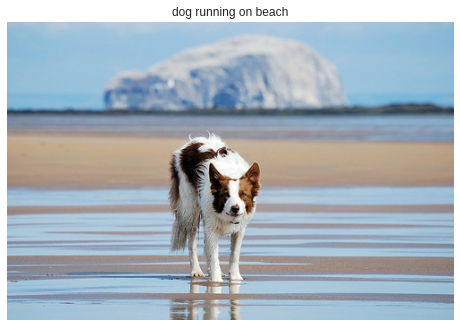

man sits on bench on san diego street
[['man', 'sits', 'on', 'bench', 'on', 'san', 'diego', 'street']] ['man', 'in', 'black', 'shirt', 'and', 'jeans', 'is', 'standing', 'in', 'front', 'of', 'an', 'old', 'building']
bleu 0.33508109344644055


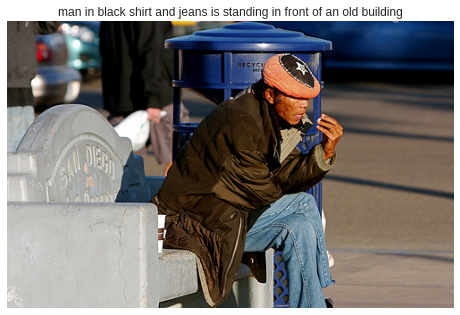

snowboarder is doing flip over mound of snow
[['snowboarder', 'is', 'doing', 'flip', 'over', 'mound', 'of', 'snow']] ['man', 'in', 'black', 'shirt', 'and', 'black', 'shorts', 'is', 'jumping', 'on', 'his', 'board']
bleu 0.4372633844789293


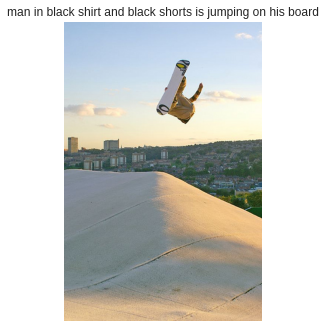

boy in blue bathing suit jumps with his arms in the air in backyard setting
[['boy', 'in', 'blue', 'bathing', 'suit', 'jumps', 'with', 'his', 'arms', 'in', 'the', 'air', 'in', 'backyard', 'setting']] ['little', 'girl', 'in', 'pink', 'bathing', 'suit', 'is', 'running', 'through', 'the', 'grass']
bleu 0.6162043140611316


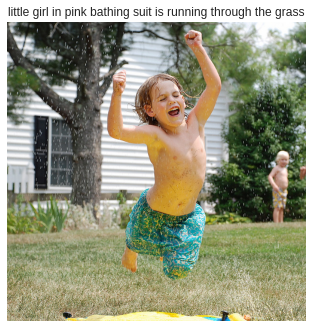

boy in tan coat throws some red leaves at the camera
[['boy', 'in', 'tan', 'coat', 'throws', 'some', 'red', 'leaves', 'at', 'the', 'camera']] ['little', 'girl', 'in', 'dress', 'is', 'blowing', 'around', 'in', 'the', 'air']
bleu 0.5475101233634038


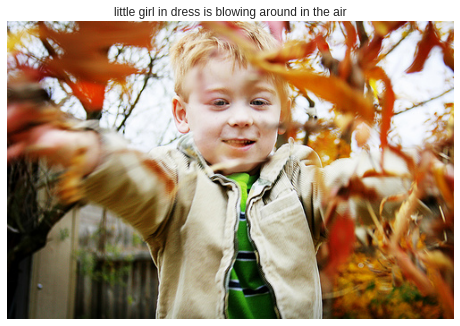

child in formal clothing is walking along the edge of stony area that is littered in places
[['child', 'in', 'formal', 'clothing', 'is', 'walking', 'along', 'the', 'edge', 'of', 'stony', 'area', 'that', 'is', 'littered', 'in', 'places']] ['man', 'in', 'red', 'shirt', 'and', 'black', 'pants', 'is', 'standing', 'on', 'the', 'grass']
bleu 0.6300791824315647


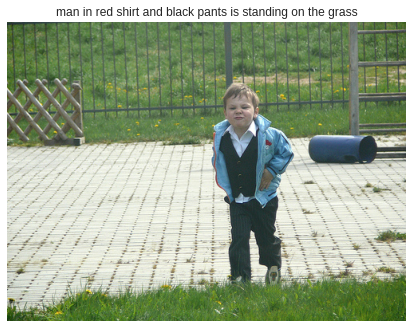

group of children playing in sprinkler
[['group', 'of', 'children', 'playing', 'in', 'sprinkler']] ['child', 'in', 'blue', 'shirt', 'is', 'jumping', 'into', 'pool']
bleu 0.37462215426558176


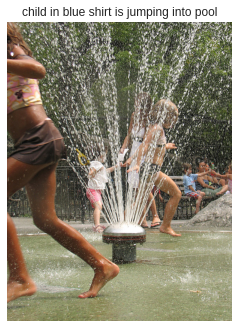

black dog is running across rocky landscape
[['black', 'dog', 'is', 'running', 'across', 'rocky', 'landscape']] ['man', 'and', 'woman', 'walk', 'away', 'from', 'the', 'side', 'of', 'the', 'road']
bleu 0.2253085742391445


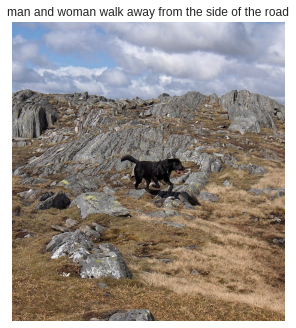

dog in the snow
[['dog', 'in', 'the', 'snow']] ['two', 'dogs', 'play', 'in', 'the', 'snow']
bleu 0.5900974197055616


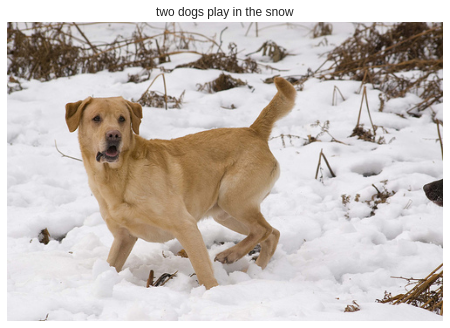

coach talks to football player during timeout
[['coach', 'talks', 'to', 'football', 'player', 'during', 'timeout']] ['two', 'football', 'teams', 'are', 'tackling', 'each', 'other']
bleu 0.5660176946306076


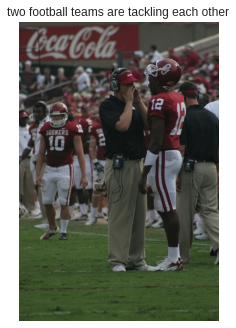

dog leaps out of the water
[['dog', 'leaps', 'out', 'of', 'the', 'water']] ['dog', 'running', 'through', 'the', 'water']
bleu 0.8119753378878182


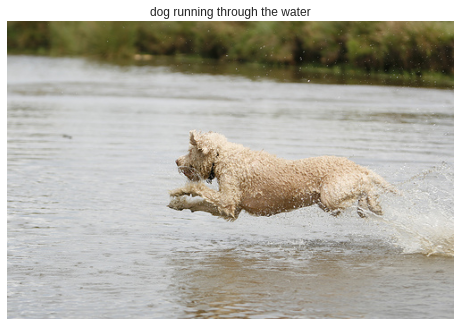

boy soccer player running down the field
[['boy', 'soccer', 'player', 'running', 'down', 'the', 'field']] ['two', 'men', 'in', 'blue', 'jerseys', 'are', 'playing', 'soccer']
bleu 0.5721248424548514


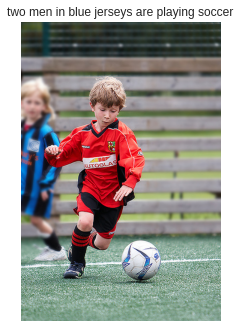

man is climbing the mountain
[['man', 'is', 'climbing', 'the', 'mountain']] ['man', 'in', 'red', 'jacket', 'is', 'sitting', 'on', 'top', 'of', 'mountain']
bleu 0.5773421017938712


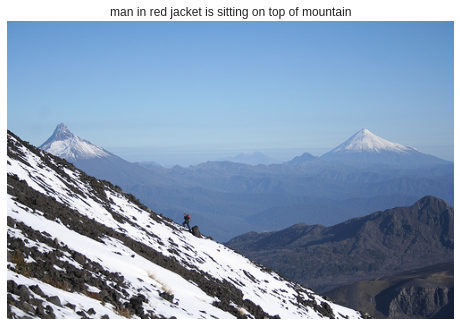

girl in pink dress blows bubbles on wharf
[['girl', 'in', 'pink', 'dress', 'blows', 'bubbles', 'on', 'wharf']] ['two', 'girls', 'are', 'standing', 'in', 'front', 'of', 'window']
bleu 0.5994978266967533


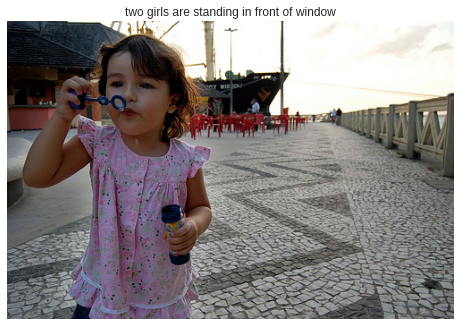

boy dribbles basketball in the gymnasium
[['boy', 'dribbles', 'basketball', 'in', 'the', 'gymnasium']] ['boy', 'in', 'blue', 'shirt', 'and', 'white', 'sneakers', 'is', 'kicking', 'basketball']
bleu 0.536762533707832


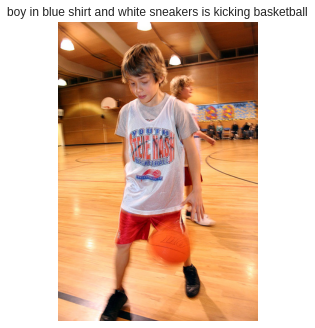

In [ ]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2560))

    i = plt.imread("/content/Flickr8k_Dataset/Flicker8k_Dataset/"+img_name+".jpg")
    print(train_descriptions[img_name])
    caption = predict_caption(photo_2048)
    #corpus_bleu(, predicted, weights=(1.0, 0, 0, 0)
    #print(caption)

    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

In [ ]:
def evaluate_model(model, train_descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list() #generate two lists
	# iterate through all descriptions
	for key, desc_list in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual desciption and predicted caption
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	# calculate BLEU scores 1-4
	print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
	print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
	print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
	print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))